# TP 1 - Reinforcement Learning (November 16rd)

Name : Dorin Doncenco

### Instructions
This assignement will be a discovery of a library for working with RL problems,   an implementation of Policy Iteration and Value Iteration algorithm and the first implementation of a sampling-based algorithm.

We used the Cliff Walking Environment (also from Sutton's book).

    Adapted from Example 6.6 (page 132) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center
    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.

(https://gymnasium.farama.org/_images/cliff_walking.gif "Cliff Walking")

- Save this notebook in a ```.ipynb``` format and send it to cyriaque.rousselot(at)inria(dot)fr with the name ```TP1_NAME_SURNAME``` before November 23th.
- Make sure to comment your code and explain your decisions clearly. Write explanations in text if necessary 
- Answers must be short and precise and don't require thousands lines of code. 
- Generally, the code to complete is indicated with the comment ```#TO IMPLEMENT```
Good luck !


## A gentle start with Gymnasium

Have a look at the documentation of gymnasium https://gymnasium.farama.org/content/basic_usage/, of environments https://gymnasium.farama.org/api/env/ and of the Cliff Walking Environment https://gymnasium.farama.org/environments/toy_text/cliff_walking/. 


> You can use multiple render_mode in a gym environment class. For simplicity, I will ask you to render the environment in ansi mode to display it in the notebook.

**Q.1 Display the Action Space / State space of the CliffWalking environment**

In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 431 µs (started: 2023-11-16 09:27:48 +01:00)


In [25]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

print("="*10 + "Load the environment"+"="*10)
env = gym.make('CliffWalking-v0', render_mode="ansi") # Initialize the environment object
observation, info = env.reset(seed=42) # Reset the environment

print("="*10 + "Visualize the environment"+"="*10)
print(env.render()) # The Cliff Walking Environment in ANSI 

## Action Space
nb_actions = 4
print("="*10 + "Action Space"+"="*10)
action_space = env.action_space
print(action_space)

## State space
nb_states = 48
print("="*10 + "State Space"+"="*10)
state_space = env.observation_space
print(state_space)

env.close()

==========Load the environment==========
==========Visualize the environment==========
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


==========Action Space==========
Discrete(4)
==========State Space==========
Discrete(48)
time: 27.7 ms (started: 2023-11-16 09:46:17 +01:00)


### Use of a random policy

**Q.2 Implement a policy that chose an action randomly from the action space and a policy that chose always the action "go right"**

In [46]:
def RandomPolicy(state,action_space):
    #select random from action_space
    return action_space.sample()
    
def GoRightPolicy(state,action_space):
    #select right action, according to docs the action_space = [up,right,down,left]
    return 1

def GoUpPolicy(state,action_space):
    #select up action, according to docs the action_space = [up,right,down,left]
    return 0

time: 1.35 ms (started: 2023-11-16 10:02:05 +01:00)


**Q.3 What is the meaning of the ouptut of the method ```step()``` of the environment class ?**

In [27]:
env = gym.make('CliffWalking-v0',render_mode="ansi")
env.reset()
print(env.step(2))
env.close()

(36, -1, False, False, {'prob': 1.0})
time: 9.35 ms (started: 2023-11-16 09:47:06 +01:00)


In [31]:
env.step(0)

(12, -1, False, False, {'prob': 1.0})

time: 3.73 ms (started: 2023-11-16 09:59:36 +01:00)


**Q.4 Build a function ```transition(env,s1,Pi)``` that take in entry the environment, a state and a ```policy(state,action_space)``` function. It has to return the immediate reward ,the next state and a boolean that indicates if the next step is a terminal state.**

In [172]:
def transition(env,s1,Pi):
    # take in environment, state, and policy, and return reward, next state, and bool of terminal state
    action = Pi(s1,env.action_space)
    state, reward, done, _, _ = env.step(action)

    return reward, state, done

env= gym.make('CliffWalking-v0',render_mode='ansi')
s0 = env.reset()[0]
print(transition(env,s0,RandomPolicy)) 
env.close()

(-100, 36, False)
time: 14.1 ms (started: 2023-11-16 11:25:16 +01:00)


In [173]:
# do some policy 10 times
env = gym.make('CliffWalking-v0',render_mode='ansi')
s0 = env.reset()[0]
for i in range(10):
    print(transition(env,s0,GoUpPolicy))
env.close()


(-1, 24, False)
(-1, 12, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
(-1, 0, False)
time: 12.5 ms (started: 2023-11-16 11:25:17 +01:00)


**Q.5 Build a function ```SimulateTrajectory(T,policy)``` that simulate the behavior of an agent that start at an initial state, chose its next states using ```policy(state,action_space)``` function and keep trace of the state visited and the rewards obtained. It stops after ```T``` steps or if it encounters a terminal state. Use this function to plot the Cumulated Discounted Reward for multiple initialisations**
>(Hint: you can use the function defined in question Q.4)

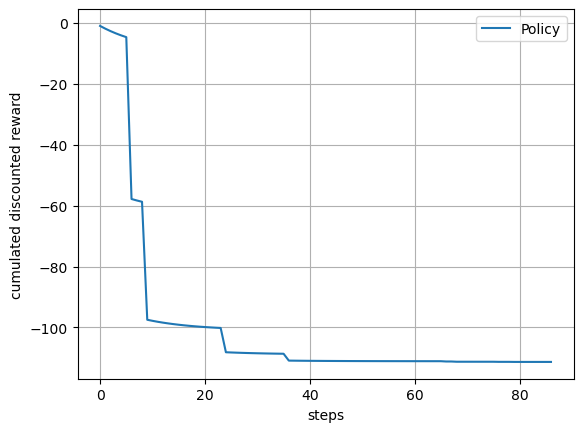

time: 409 ms (started: 2023-11-16 11:25:19 +01:00)


In [174]:
def SimulateTrajectory(T,policy):
    """return a vector of T successive states and a vector of T successive immediate rewards"""
    env = gym.make('CliffWalking-v0',render_mode='ansi')
    s0 = env.reset()[0]
    states = [s0]
    rewards = []
    for t in range(T):
        r,s,done = transition(env,states[-1],policy)
        states.append(s)
        rewards.append(r)
        if done:
            break
    env.close()
    return states,rewards

gamma = 0.9 # discount factor 
T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum 
States1,Rewards1 = SimulateTrajectory(T, RandomPolicy)

# Plot cumulative discounted reward (on a single run):
plt.figure()
plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(T)])),label="Policy")

plt.xlabel('steps')
plt.ylabel('cumulated discounted reward')
plt.legend()
plt.grid()
plt.show()


$ \frac{log(\frac{1}{(10^{-3}*(1-\gamma))})}{log(\frac{1}{\gamma})} $

**Q.6 Implement the optimal policy and display a corresponding trajectory from the initial state.**

In [175]:
def OptimalPolicy(state, action_space):
    if state==36:
        return 0
    elif state in [11, 23, 35]:
        return 2
    else:
        return 1

time: 1.11 ms (started: 2023-11-16 11:25:21 +01:00)


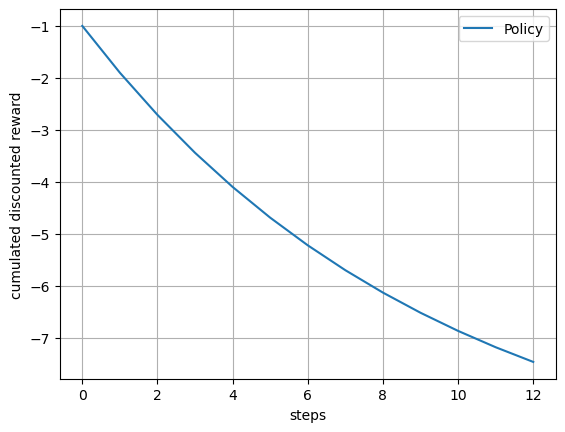

time: 310 ms (started: 2023-11-16 11:25:21 +01:00)


In [176]:
States1,Rewards1 = SimulateTrajectory(T, OptimalPolicy)

# Plot cumulative discounted reward (on a single run):
plt.figure()
plt.plot(np.cumsum(Rewards1*np.array([gamma**t for t in range(len(States1)-1)])),label="Policy")

plt.xlabel('steps')
plt.ylabel('cumulated discounted reward')
plt.legend()
plt.grid()
plt.show()

# Dynamic Programming

In order to use our dynamic programming algorithms, we need to know the parameters of the MDP. 
Here we know the reward and transition model. 

**Q.7 Fill the reward array ```r[s,a]```, the transition array ```p[s,a,s']``` and the terminal array ```T[s]``` that return a boolean if the state is terminal.**


> Hint : You can look at https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py

In [186]:
# Can be useful 
def number_to_grid(x): # Convert a state number into its coordinates on the grid.
    return(np.unravel_index(np.array(x),shape=(4,12)))

def grid_to_number(x):
    return(np.ravel_multi_index(x,(4,12)))


# MDP parameters
nb_states = 48
nb_actions = 4
P = np.zeros((nb_states,nb_actions,nb_states)) # P[s,a,s'] = p(s' | s,a) 
r = np.zeros((nb_states,nb_actions)) # r[s,a] =  reward received in state s when playing action a
T = np.zeros(nb_states,dtype=bool) # T[s] = True if s is a terminal state
# Fill P and r
env = gym.make('CliffWalking-v0',render_mode='ansi')
for s in range(nb_states):
    for a in range(nb_actions):
        for prob, next_state, reward, done in env.P[s][a]:
            P[s,a,next_state] = prob
            r[s,a] = reward
            T[s] = done
r[35][2] = 0

# evaluate only on not terminal states

time: 16.7 ms (started: 2023-11-16 11:28:29 +01:00)


/home/dorin/miniconda3/envs/uni_env/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [182]:
def sample_next_state(P,s,a): # sampling method for next state given current state and action
    return np.random.choice(range(nb_states), 1, p=P[s,a])[0]

time: 998 µs (started: 2023-11-16 11:26:22 +01:00)


### Policy Iteration

In this section, we will consider deterministic policies. A deterministic policy  is represented as a vector pi[s] with s a state. 

In [192]:
example_pi =  np.random.choice([0,1,2,3], nb_states)  # An example of random deterministic policy

time: 740 µs (started: 2023-11-16 11:29:30 +01:00)


In [193]:
state = 13
print(f"The action from state {state} is {example_pi[state]}")

The action from state 13 is 2
time: 752 µs (started: 2023-11-16 11:29:36 +01:00)


**Q.8 Using the Bellman equations, build a function for evaluating the state-value function $V_\pi$ of a policy $\pi$ iteratively. We consider convergence with $\epsilon = 0.01$ or if we performed a maximum of 10000 iterations.**
> Hint : you can look at Sutton & Barto , Reinforcement Learning, An introduction, chapter 4

In [ ]:
epsilon = 0.01
max_iter = 10000
def policy_evaluation(policy, epsilon, gamma, max_iter):
    V = -200*np.ones(nb_states) # intialize Values to 0's
    

**Q.9 Build a policy improvement function**

In [ ]:
def policy_improve(V, policy):
    return policy
    # TO IMPLEMENT

**Q.10 Using the two preceding functions, build the Policy Iteration algorithm**

In [ ]:
def policy_iteration(epsilon,gamma,max_iter):
    #TO IMPLEMENT
    pass

In [ ]:
epsilon = 0.01
gamma = 0.9
max_iter = 10000
policy = policy_iteration(epsilon, gamma, max_iter)
print(policy.reshape(4,12))

**Q.11 Test your obtained policy and compare it against random policies. Is it optimal ?** 

### Value Iteration

**Q.12 Similarly to the Policy Iteration algorithm, build the Value Iteration Algorithm and test it.**

# Our first sampling algorithm

Now we don't have access to the Reward and Transitions table anymore ! We will have to explore to build our knowledge of an estimation of the action-value Q(s,a) along the way.

**Q.13 Read the pseudo-code for the Monte Carlo Exploring Starts algorithms. Describe briefly how the algorithm allows in theory to get a good policy.**
![Alt text](image.png)

**Q.14 Why can this algorithm be not efficient ?**

**Q.15  Implement a Monte Carlo Exploring Starts algorithm.**

We will store action-value information in a table q[s,a] that will be updated at each episode. 

You will need :
- To store ```pi```, ```q[s,a]``` as tables and ```Returns(s,a)``` as a list of cumulative discounted rewards
- To reset the environment for each episode. 
- To use the ```step()``` method to act on the environment 
- To update your knowledge of q on the trajectory of the episode.
- To update the current policy given the update of q.


**Q.16 Visualize the obtained policy after training over some iterations and conclude**